In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.usetex'] = True # use latex for all text handling
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{siunitx}', r'\usepackage{amsmath}']

# to just create static png plots use 
%matplotlib inline

# to allow interactive plots use 
# %matplotlib notebook

# use jupyter nbconvert --to python <notebook_name.ipynb> to convert to python script

# if having trouble with errors like cannot import _backports go to Kernel toolbar
# and select Restart & Clear Output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from PyDakota.regression import *
from PyDakota.models.genz import GenzFunction
from PyDakota.approximation import *
from PyDakota.math_tools import compute_hyperbolic_indices
from multiprocessing import Pool
import time
from scipy.misc import comb
from functools import partial
#import numpy

numpy.random.seed(3)

num_vars = 2
variables = BoundedVariables()
ranges = define_homogeneous_ranges(num_vars, 0., 1.);
variables.set_ranges(ranges)

function = GenzFunction('oscillatory',num_vars)
function.set_coefficients(10., 'no-decay')

var_transform = AffineVariableTransformation()
var_transform.set_variables(variables)

Solve for coefficients using entire data and for $\epsilon=0$ 

In [ ]:
degree = 10
approx = Monomial()
approx.set_variable_transformation(var_transform)
basis_indices = compute_hyperbolic_indices(num_vars, degree, 1.)
approx.set_basis_indices(basis_indices)

num_training_samples = 2*basis_indices.shape[1]

def cross_validated_solve(basis_matrix, training_function_vals,
                          regression_type, regression_opts, seed):
    regression_opts['cv-opts']['seed']=seed
    cv_solver = CrossValidatedSolver()
    cv_solver.set_linear_system_solver(regression_type)
    cv_solver.solve(basis_matrix, training_function_vals, regression_opts)
    scores = cv_solver.get_best_scores()
    solutions = cv_solver.get_final_solutions()
    return scores, solutions

num_folds = 10;
regression_type=SVD_LEAST_SQ_REGRESSION
function_opts = {'eval_type':'value-grad'}
cv_opts = {'num-points':num_training_samples,'num-folds':num_folds}
regression_opts = {'verbosity':0,'cv-opts':cv_opts,'store-history':True}

def cross_validated_solve_helper(args):
    return cross_validated_solve(*args)

num_trials = 1000; num_bins=100
import multiprocessing
max_eval_concurrency=1#max(multiprocessing.cpu_count()-2,1)
from multiprocessing import Pool
import time
t0 = time.time()
pool = Pool(max_eval_concurrency)
args = []
seeds = numpy.random.permutation(numpy.arange(1,10*num_trials))[:num_trials]
for i in range(num_trials):
    training_samples = numpy.random.uniform(0,1,(num_vars,num_training_samples))
    training_function_vals = function.value(training_samples,function_opts)
    basis_matrix = approx.generate_basis_matrix(training_samples)
    args.append([basis_matrix,training_function_vals,regression_type,regression_opts,seeds[i]])
result = numpy.asarray(pool.map(cross_validated_solve_helper,args))
print 'that_took:', time.time()-t0

num_validation_samples = 1000
validation_samples = numpy.random.uniform(0,1,(num_vars,num_validation_samples))
validation_vals = function.value(validation_samples,function_opts)

t0 = time.time()    
mse = []
cv_scores = []
for i in range(num_trials):
    cv_scores_i, solutions = result[i]
    cv_scores.append(cv_scores_i)
    approx.set_coefficients(solutions)
    approx_validation_vals = approx.value(validation_samples)
    mse.append(numpy.linalg.norm(approx_validation_vals-validation_vals,axis=0)**2/num_validation_samples)
mse = numpy.asarray(mse)
cv_scores = numpy.asarray(cv_scores)
print 'that_took:', time.time()-t0

num_rhs = mse[0].shape[0]
f,axs=plt.subplots(1,num_rhs,sharey=True,figsize=(16, 6))
axs = axs.ravel()
for j in range(num_rhs):
    bins=numpy.logspace(numpy.log10(mse[:,j].min()),numpy.log10(mse[:,j].max()), num_bins)
    n, bins, patches = axs[j].hist(mse[:,j], bins=bins, normed=None, facecolor='green', alpha=0.5,label='Err')
    bins=numpy.logspace(numpy.log10(cv_scores[:,j].min()),numpy.log10(cv_scores[:,j].max()), num_bins)
    n, bins, patches = axs[j].hist(cv_scores[:,j], bins=bins, normed=None, facecolor='blue', alpha=0.75,label='CV score')
    axs[j].set_xscale("log")

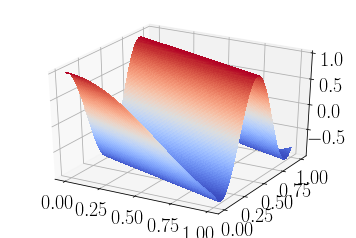

In [7]:
from PyDakota.plot_3d import get_meshgrid_function_data, plot_surface
X,Y,Z = get_meshgrid_function_data(function.value, [0,1,0,1], 100, qoi = 0)
plot_surface(X, Y, Z, ax=None, samples=None, limit_state=None,
             num_contour_levels=0, plot_axes=True, cmap=mpl.cm.coolwarm,
             axis_labels=None, angle=None, alpha=1., zorder=None)

# Cross Validation
## Quotes from hastie datamining book: 
Page 220: Definition of training and test (prediction error)
$$Err_\mathcal{X}=\operatorname{E}_{\mathcal{X}_{test}}[L(f(\mathcal{X}_{test}),\hat{f}(\mathcal{X}_{test},p)\mid\mathcal{X_{train}})]$$

$$Err=\operatorname{E}_\mathcal{X_{train}}[Err_\mathcal{X}]$$

Page 221:training error is not a good estimate of the test error,
as seen in Figure 7.1. Training error consistently decreases with model
complexity, typically dropping to zero if we increase the model complexity
enough. However, a model with zero training error is overfit to the training
data and will typically generalize poorly.

Page 243: To summarize, if the learning curve has a considerable slope at the given
training set size, five- or tenfold cross-validation will overestimate the true
prediction error. Whether this bias is a drawback in practice depends on
the objective. On the other hand, leave-one-out cross-validation has low
bias but can have high variance. Overall, five- or tenfold cross-validation
are recommended as a good compromise: see Breiman and Spector (1992)
and Kohavi (1995).
